In [1]:
import numpy as np
from pyrex.main import *
from pyrex.core import *
import matplotlib.pyplot as plt
import lal
import lalsimulation as ls
from pycbc.types import TimeSeries
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter.matchedfilter import make_frequency_series
from pycbc.filter import matched_filter_core,sigmasq
from pycbc.types import complex_same_precision_as
from pycbc.waveform import get_td_waveform

In [2]:
data_path = "/Users/yesety/Documents/AEI/projects/eccentric/catalog_ecc/"

name=[]
name.append(['SXS_BBH_0180','SXS_BBH_1355','SXS_BBH_1357','SXS_BBH_1358','SXS_BBH_1359','SXS_BBH_1360','SXS_BBH_1361','SXS_BBH_1362','SXS_BBH_1363'])
name.append(['SXS_BBH_0184','SXS_BBH_1364','SXS_BBH_1365','SXS_BBH_1366','SXS_BBH_1367','SXS_BBH_1368','SXS_BBH_1369'])
name.append(['SXS_BBH_0183','SXS_BBH_1372','SXS_BBH_1373','SXS_BBH_1374'])

e_comm=[]
e_comm.append([0,0.053,0.097,0.099,0.100,0.142,0.144,0.189,0.192])
e_comm.append([0,0.044,0.06,0.095,0.096,0.097,0.185])
e_comm.append([0,0.092,0.093,0.18]) #Hinder Phys Rev D 98 2018

l_comm=[]
l_comm.append([0.667,-2.788,1.371,-1.742,2.743,2.178,1.550,1.042,0.732])
l_comm.append([-0.604,2.144,1.938,1.013,-0.709,-1.963,-1.465])
l_comm.append([1.818,2.998,1.677,-0.265]) #Hinder Phys Rev D 98 201

q=[]
q.append(list(np.ones(len(e_comm[0]))+0))
q.append(list(np.ones(len(e_comm[1]))+1))
q.append(list(np.ones(len(e_comm[2]))+2))

data={}
data['name']=name[0]+name[1]+name[2]
data['e_comm']=e_comm[0]+e_comm[1]+e_comm[2]
data['q']=q[0]+q[1]+q[2]
data['l_comm']=l_comm[0]+l_comm[1]+l_comm[2]

In [3]:
data_training={}
data_training['name']=np.concatenate([data['name'][:3],data['name'][7:11],data['name'][14:17],data['name'][18:]])
data_training['e_comm']=np.concatenate([data['e_comm'][:3],data['e_comm'][7:11],data['e_comm'][14:17],data['e_comm'][18:]])
data_training['q']=np.concatenate([data['q'][:3],data['q'][7:11],data['q'][14:17],data['q'][18:]])
data_training['l_comm']=np.concatenate([data['l_comm'][:3],data['l_comm'][7:11],data['l_comm'][14:17],data['l_comm'][18:]])

data_test={}
for i in range(len(data['name'])):
    if data['name'][i] not in data_training['name']:
        data_test.setdefault('name', []).append(data['name'][i])
        data_test.setdefault('e_comm', []).append(data['e_comm'][i])
        data_test.setdefault('q', []).append(data['q'][i])
        data_test.setdefault('l_comm', []).append(data['l_comm'][i])

In [4]:
data_all=Glassware(q=data['q'],chi=0,data_path=data_path,names=data['name'],e_ref=data['e_comm'],outfname='../data/all.pkl')

In [5]:
training=Glassware(q=data_training['q'],chi=0,data_path=data_path,names=data_training['name'],e_ref=data_training['e_comm'])

In [6]:
for i in range(len(data_all.names)):
    if data_all.names[i] not in training.names:
        data_test.setdefault('h22', []).append(data_all.h22[i])
        data_test.setdefault('time', []).append(data_all.time[i])

In [7]:
x_test=[]
for i in range(len(data['name'])):
    if data['name'][i] not in data_training['name']:
        x_test.append(data_all.x[i])
x_test

[0.14137733594267635,
 0.13275716741866606,
 0.11026178330402492,
 0.11961614256645847,
 0.12375586331071667,
 0.1429315653824314,
 0.13822550574078415,
 0.1259671936934662]

In [8]:
total_mass=50.

approximant1='IMRPhenomD'
approximant2='SEOBNRv4'
spin1x=0.
spin1y=0.
spin1z=0.
spin2x=0.
spin2y=0.
spin2z=0.

inclination=0.
distance=1.
coa_phase=0.

In [9]:
_snr = None
def modify_match(vec1, vec2, vec3, vec4, psd=None, low_frequency_cutoff=None,
          high_frequency_cutoff=None, v1_norm=None, v2_norm=None):
    """ Return the match between the two TimeSeries or FrequencySeries.

    Return the match between two waveforms. This is equivalent to the overlap
    maximized over time and phase.

    Parameters
    ----------
    vec1 : TimeSeries or FrequencySeries
        The input vector containing a waveform.
    vec2 : TimeSeries or FrequencySeries
        The input vector containing a waveform.
    psd : Frequency Series
        A power spectral density to weight the overlap.
    low_frequency_cutoff : {None, float}, optional
        The frequency to begin the match.
    high_frequency_cutoff : {None, float}, optional
        The frequency to stop the match.
    v1_norm : {None, float}, optional
        The normalization of the first waveform. This is equivalent to its
        sigmasq value. If None, it is internally calculated.
    v2_norm : {None, float}, optional
        The normalization of the second waveform. This is equivalent to its
        sigmasq value. If None, it is internally calculated.

    Returns
    -------
    match: float
    index: int
        The number of samples to shift to get the match.
    """
    
    htilde = make_frequency_series(vec1)    
    stilde = make_frequency_series(vec2)
    h_imag=make_frequency_series(vec3)*1j
    s_im=make_frequency_series(vec4)*1j
    htilde=htilde+h_imag
    stilde=stilde+s_im
    
    

    N = (len(htilde)-1) * 2

    global _snr
   
    if _snr is None or _snr.dtype != htilde.dtype or len(_snr) != N:
        _snr = np.zeros(N,dtype=complex_same_precision_as(vec1))
   
    snr, a, snr_norm = matched_filter_core(htilde,stilde,psd,low_frequency_cutoff,high_frequency_cutoff, v1_norm, out=None)
    maxsnr, max_id = snr.abs_max_loc()
    if v2_norm is None:
        v2_norm = sigmasq(stilde, psd, low_frequency_cutoff, high_frequency_cutoff)
    return maxsnr * snr_norm / np.sqrt(v2_norm), max_id

In [13]:
def resizeWave(time,strain,newtime,samplerate):  
    deltaT=1./samplerate
    newtime=np.arange(min(newtime),max(newtime),deltaT)
    inter_real=spline(time,np.real(strain))
    inter_im=spline(time,np.imag(strain))
    time_real=TimeSeries(inter_real(newtime),delta_t=deltaT)
    time_im=TimeSeries(inter_im(newtime),delta_t=deltaT)
    return time_real,time_im

def compute_match(testtime,testh,timemodel,mdlh,newtm,samplerate):
    nrdt,nid=resizeWave(testtime,testh,newtm,samplerate)
    mdt,mdi=resizeWave(timemodel,mdlh,newtm,samplerate)    
    f_lower=25.
    tlen=len(nrdt)
    delta_f = 1.0 / nrdt.duration
    flen = tlen//2 + 1
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_lower)
    cmatch=modify_match(nrdt,mdt,nid,mdi,psd=psd,low_frequency_cutoff=f_lower)
    return cmatch[0]

In [14]:
eccen_matchphen=[]
ecccen_matchseob=[]
newt=np.linspace(-1500,-50.4,15000)
for i in range(len(data_test['time'])):
    m1,m2=masses_from_q(data_test['q'][i],total_mass)
    mass1=m1
    mass2=m2
    samplerate=4096
    x=x_test[i]
    eccentricity=data_test['e_comm'][i]
    testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    scale=NR_amp_scale(total_mass,distance)
    y22=find_Y22(inclination,coa_phase)
    matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time/(total_mass*lal.MTSUN_SI),testPhenom.h22/(scale*y22),newt,samplerate)
    matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time/(total_mass*lal.MTSUN_SI),testSEOB.h22/(scale*y22),newt,samplerate)
    eccen_matchphen.append(matchPhnm)
    ecccen_matchseob.append(matchSEOB)
    print(data_test['e_comm'][i],data_test['q'][i],matchPhnm,matchSEOB)

training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.099 1.0 0.9999997706698942 0.9999987148674867
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.1 1.0 0.999999877688331 0.9999982485203928
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.142 1.0 0.9999996717265615 0.9999998435305961
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.144 1.0 0.9999990444733672 0.9999996362785323
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.06 2.0 0.999999190983637 0.9999998449519448
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.095 2.0 0.9999991616358426 0.9999999999498888
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.096 2.0 0.9999989872758575 0.9999999993765503
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.092 3.0 0.9999981760022731 0.9999980330379283


0.9999997254415428
0.9999997254415428
0.9999997254415428
0.9999997254415428
0.9999997254415428
0.9999997254415428
0.9999997254415428
0.9999997254415428
0.9999997254415428
0.9999997254415428


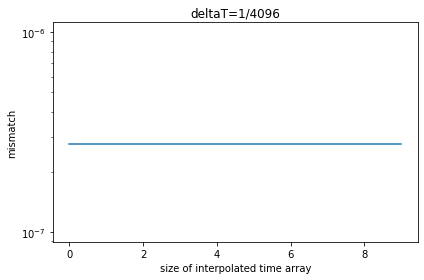

In [17]:
data_sizes = 10**np.linspace(2, 6, 10)
matches = np.zeros_like(data_sizes)
for ind, length in enumerate(data_sizes):
    newt=np.linspace(-1500,-50.4,length)
    matches[ind] = compute_match(testPhenom.time/(total_mass*lal.MTSUN_SI),testPhenom.h22/(scale*y22),testSEOB.time/(total_mass*lal.MTSUN_SI),testSEOB.h22/(scale*y22),newt,4096)
    print(matches[ind])
    
plt.semilogy(1-matches)
plt.ylabel('mismatch')
plt.title('deltaT=1/'+str(samplerate))
plt.xlabel('size of interpolated time array')
plt.tight_layout()

(-0.5, 0.1)

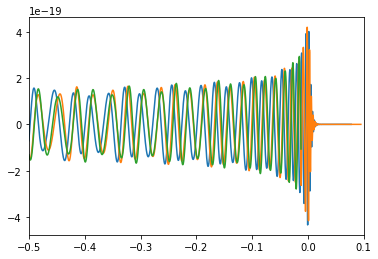

In [31]:
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:])
plt.plot(testSEOB.time,testSEOB.h22)
plt.plot(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22))
plt.xlim(-0.5,0.1)

In [114]:
eccen_matchphen=[]
ecccen_matchseob=[]
newt=np.linspace(-1500,-50.4,15000)
for i in range(len(data_test['time'])):
    m1,m2=masses_from_q(data_test['q'][i],total_mass)
    mass1=m1
    mass2=m2
    x=x_test[i]
    eccentricity=data_test['e_comm'][i]
    testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time,testPhenom.h22,newt)
    matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time,testSEOB.h22,newt)
    eccen_matchphen.append(matchPhnm)
    ecccen_matchseob.append(matchSEOB)
    print(data_test['e_comm'][i],data_test['q'][i],matchPhnm,matchSEOB)

training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.099 1.0 0.9999999899966844 0.9999999950078949
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.1 1.0 0.9999999941775144 0.9999999897056183
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.142 1.0 0.9999999843996068 0.9999999777677149
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.144 1.0 0.9999999951428848 0.9999999926285428
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.06 2.0 0.9999999999577582 0.9999999999528502
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.095 2.0 0.9999999983314976 0.9999999990369892
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.096 2.0 0.9999999997549326 0.9999999998150022
training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl
0.092 3.0 0.9999999903115714 0.9999999981906611


training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl


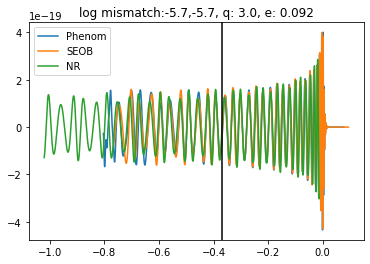

In [34]:
i=7    
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time/(total_mass*lal.MTSUN_SI),testPhenom.h22/(scale*y22),newt,samplerate)
matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time/(total_mass*lal.MTSUN_SI),testSEOB.h22/(scale*y22),newt,samplerate)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],testSEOB.h22[50:]*np.exp(-np.pi/2*1j),label='SEOB')
plt.plot(data_test['time'][7]*(total_mass*lal.MTSUN_SI),data_test['h22'][7]*(scale*y22)*np.exp(-np.pi/2*1j),label='NR')
plt.legend()
plt.title('log mismatch:'+str(round(np.log10(1-matchPhnm),1))+','+str(round(np.log10(1-matchSEOB),1))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500*(total_mass*lal.MTSUN_SI),color='k')


training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl


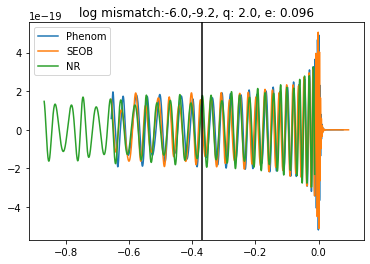

In [35]:
i=6    
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time/(total_mass*lal.MTSUN_SI),testPhenom.h22/(scale*y22),newt,samplerate)
matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time/(total_mass*lal.MTSUN_SI),testSEOB.h22/(scale*y22),newt,samplerate)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],testSEOB.h22[50:]*np.exp(3./5*np.pi*1j),label='SEOB')
plt.plot(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22)*np.exp(np.pi/2*1j),label='NR')
plt.legend()
plt.title('log mismatch:'+str(round(np.log10(1-matchPhnm),1))+','+str(round(np.log10(1-matchSEOB),1))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500*(total_mass*lal.MTSUN_SI),color='k')

training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl


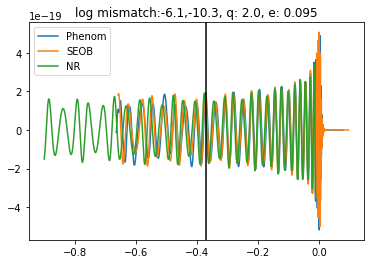

In [36]:
i=5    
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time/(total_mass*lal.MTSUN_SI),testPhenom.h22/(scale*y22),newt,samplerate)
matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time/(total_mass*lal.MTSUN_SI),testSEOB.h22/(scale*y22),newt,samplerate)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],testSEOB.h22[50:]*np.exp(2./3*np.pi*1j),label='SEOB')
plt.plot(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22)*np.exp(-np.pi/2*1j),label='NR')
plt.legend()
plt.title('log mismatch:'+str(round(np.log10(1-matchPhnm),1))+','+str(round(np.log10(1-matchSEOB),1))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500*(total_mass*lal.MTSUN_SI),color='k')

training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl


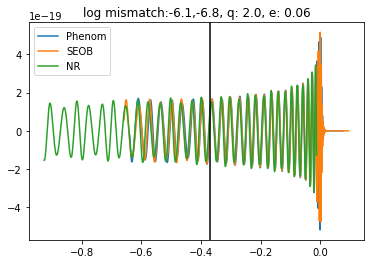

In [37]:
i=4   
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time/(total_mass*lal.MTSUN_SI),testPhenom.h22/(scale*y22),newt,samplerate)
matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time/(total_mass*lal.MTSUN_SI),testSEOB.h22/(scale*y22),newt,samplerate)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],testSEOB.h22[50:]*np.exp(np.pi*1j),label='SEOB')
plt.plot(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22)*np.exp(-np.pi/3*1j),label='NR')
plt.legend()
plt.title('log mismatch:'+str(round(np.log10(1-matchPhnm),1))+','+str(round(np.log10(1-matchSEOB),1))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500*(total_mass*lal.MTSUN_SI),color='k')

training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl


(-0.4432941922989218, 0.002462745512771788)

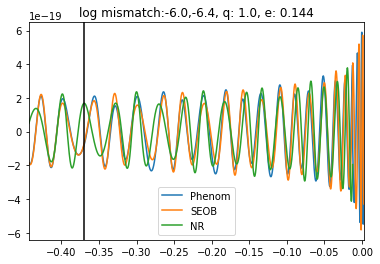

In [39]:
i=3   
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time/(total_mass*lal.MTSUN_SI),testPhenom.h22/(scale*y22),newt,samplerate)
matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time/(total_mass*lal.MTSUN_SI),testSEOB.h22/(scale*y22),newt,samplerate)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],testSEOB.h22[50:]*np.exp(4./3*np.pi*1j),label='SEOB')
plt.plot(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22)*np.exp(5./2*np.pi*1j),label='NR')
plt.legend()
plt.title('log mismatch:'+str(round(np.log10(1-matchPhnm),1))+','+str(round(np.log10(1-matchSEOB),1))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500*(total_mass*lal.MTSUN_SI),color='k')
plt.xlim(-1800*(total_mass*lal.MTSUN_SI),10*(total_mass*lal.MTSUN_SI))

In [120]:
hmodel=amp*np.exp(phase*1j)
htest=hp+hc*1j

np.real(hmodel)
np.real(htest)

amp(htest)=amp(hmodel)
phase(htest)=phase(hmodel)
hmodel=hp-hc*1j


SyntaxError: can't assign to function call (<ipython-input-120-708bbd571af9>, line 7)

training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl


(-0.4432941922989218, 0.002462745512771788)

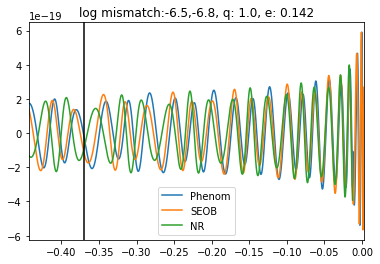

In [42]:
i=2   
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time/(total_mass*lal.MTSUN_SI),testPhenom.h22/(scale*y22),newt,samplerate)
matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time/(total_mass*lal.MTSUN_SI),testSEOB.h22/(scale*y22),newt,samplerate)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],testSEOB.h22[50:]*np.exp(-3./2*np.pi*1j),label='SEOB')
plt.plot(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22)*np.exp(-20j),label='NR')
plt.legend()
plt.title('log mismatch:'+str(round(np.log10(1-matchPhnm),1))+','+str(round(np.log10(1-matchSEOB),1))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500*(total_mass*lal.MTSUN_SI),color='k')
plt.xlim(-1800*(total_mass*lal.MTSUN_SI),10*(total_mass*lal.MTSUN_SI))


training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl


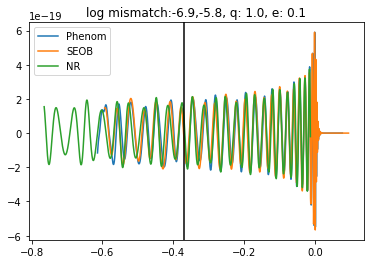

In [43]:
i=1   
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time/(total_mass*lal.MTSUN_SI),testPhenom.h22/(scale*y22),newt,samplerate)
matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time/(total_mass*lal.MTSUN_SI),testSEOB.h22/(scale*y22),newt,samplerate)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],testSEOB.h22[50:]*np.exp(-3./2*np.pi*1j),label='SEOB')
plt.plot(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22)*np.exp(1./2*np.pi*1j),label='NR')
plt.legend()
plt.title('log mismatch:'+str(round(np.log10(1-matchPhnm),1))+','+str(round(np.log10(1-matchSEOB),1))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500*(total_mass*lal.MTSUN_SI),color='k')

training data found: 
pyrexdata.pkl
training data found: 
pyrexdata.pkl


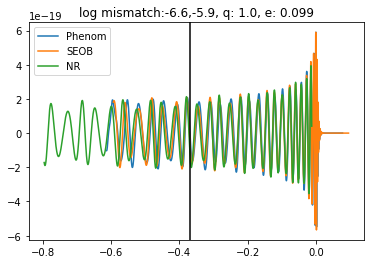

In [45]:
i=0   
m1,m2=masses_from_q(data_test['q'][i],total_mass)
mass1=m1
mass2=m2
x=x_test[i]
eccentricity=data_test['e_comm'][i]
testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time/(total_mass*lal.MTSUN_SI),testPhenom.h22/(scale*y22),newt,samplerate)
matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time/(total_mass*lal.MTSUN_SI),testSEOB.h22/(scale*y22),newt,samplerate)
plt.plot(testPhenom.time[1500:],testPhenom.h22[1500:],label='Phenom')
plt.plot(testSEOB.time[50:],testSEOB.h22[50:]*np.exp(-3./2*np.pi*1j),label='SEOB')
plt.plot(data_test['time'][i]*(total_mass*lal.MTSUN_SI),data_test['h22'][i]*(scale*y22)*np.exp(-1./5*np.pi*1j),label='NR')
plt.legend()
plt.title('log mismatch:'+str(round(np.log10(1-matchPhnm),1))+','+str(round(np.log10(1-matchSEOB),1))+', q: '+str(data_test['q'][i])+', e: '+str(data_test['e_comm'][i]))
plt.axvline(x=-1500*(total_mass*lal.MTSUN_SI),color='k')

In [47]:
eccen_matchphen=[]
ecccen_matchseob=[]
newt=np.linspace(-1500,-50.4,15000)
for i in range(len(data_test['time'])):
    m1,m2=masses_from_q(data_test['q'][i]+1,total_mass)
    mass1=m1
    mass2=m2
    x=x_test[i]
    eccentricity=data_test['e_comm'][i]+0.6
    testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time,testPhenom.h22,newt,samplerate)
    matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time,testSEOB.h22,newt,samplerate)
    eccen_matchphen.append(matchPhnm)
    ecccen_matchseob.append(matchSEOB)
    print(eccentricity,data_test['q'][i]+1,matchPhnm,matchSEOB)

(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
0.699 2.0 nan 0.9999999562984656
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
0.7 2.0 nan 0.9999999529838742
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
0.742 2.0 nan 0.9999999721000885
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
0.744 2.0 nan 0.9999999

In [50]:
eccen_matchphen=[]
ecccen_matchseob=[]
newt=np.linspace(-1500,-50.4,15000)
for i in range(len(data_test['time'])):
    m1,m2=masses_from_q(data_test['q'][i],total_mass)
    mass1=m1
    mass2=m2
    x=x_test[i]
    eccentricity=data_test['e_comm'][i]+0.8
    testPhenom=Cookware(approximant1,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    testSEOB=Cookware(approximant2,mass1,mass2,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,eccentricity,x,inclination,distance,coa_phase)
    matchPhnm=compute_match(data_test['time'][i],data_test['h22'][i],testPhenom.time[1500:],testPhenom.h22[1500:],newt,samplerate)
    matchSEOB=compute_match(data_test['time'][i],data_test['h22'][i],testSEOB.time,testSEOB.h22,newt,samplerate)
    eccen_matchphen.append(matchPhnm)
    ecccen_matchseob.append(matchSEOB)
    print(eccentricity,data_test['q'][i],matchPhnm,matchSEOB)

(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
0.899 1.0 0.9999999562984488 0.9999999562984506
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
0.9 1.0 0.9999999529838886 0.999999952983886
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
0.9420000000000001 1.0 0.9999999721000792 0.9999999721000804
(warning)>> This version has only been calibrated up to eccentricity<0.2.
training data found: 
pyrexdata.pkl
(warning)>> This version has only been calibrated up to eccentricity<0.2.
tr

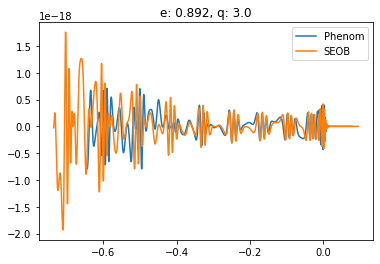

In [52]:
plt.plot(testPhenom.time[2000:],testPhenom.h22[2000:],label='Phenom')
plt.plot(testSEOB.time[200:],testSEOB.h22[200:],label='SEOB')
plt.title('e: '+str(eccentricity)+', q: '+str(data_test['q'][i]))
plt.legend()
#plt.xlim(-1500,20)


In [55]:
e_noncirc=np.concatenate((np.concatenate((data_all.e_ref[1:9],data_all.e_ref[10:16]),axis=0),data_all.e_ref[17:]),axis=0)
q_noncirc=np.concatenate((np.concatenate((data_all.q[1:9],data_all.q[10:16]),axis=0),data_all.q[17:]),axis=0)

A_omg_noncirc=np.concatenate((np.concatenate((data_all.A_omega[1:9],data_all.A_omega[10:16]),axis=0),data_all.A_omega[17:]),axis=0)
C_omg_noncirc=np.concatenate((np.concatenate((data_all.B_omega[1:9],data_all.B_omega[10:16]),axis=0),data_all.B_omega[17:]),axis=0)
fr_omg_noncirc=np.concatenate((np.concatenate((data_all.freq_omega[1:9],data_all.freq_omega[10:16]),axis=0),data_all.freq_omega[17:]),axis=0)
phi_omg_noncirc=np.concatenate((np.concatenate((data_all.phi_omega[1:9],data_all.phi_omega[10:16]),axis=0),data_all.phi_omega[17:]),axis=0)

In [56]:
e_noncirc=np.concatenate((np.concatenate((data_all.e_ref[1:9],data_all.e_ref[10:16]),axis=0),data_all.e_ref[17:]),axis=0)
q_noncirc=np.concatenate((np.concatenate((data_all.q[1:9],data_all.q[10:16]),axis=0),data_all.q[17:]),axis=0)

AA_noncirc=np.concatenate((np.concatenate((data_all.A_amp[1:9],data_all.A_amp[10:16]),axis=0),data_all.A_amp[17:]),axis=0)
CA_noncirc=np.concatenate((np.concatenate((data_all.B_amp[1:9],data_all.B_amp[10:16]),axis=0),data_all.B_amp[17:]),axis=0)
frA_noncirc=np.concatenate((np.concatenate((data_all.freq_amp[1:9],data_all.freq_amp[10:16]),axis=0),data_all.freq_amp[17:]),axis=0)
phiA_noncirc=np.concatenate((np.concatenate((data_all.phi_amp[1:9],data_all.phi_amp[10:16]),axis=0),data_all.phi_amp[17:]),axis=0)